#A Machine Learning Solution for Data-Driven Crime Analytics in South Africa





###**Student Name :** MANQELE TV
###**Student Number :** 22304903



##  Data Sources

The following datasets were collected from **Kaggle** and provide the foundation for data-driven crime analytics in South Africa.  
They include both **crime incident data** and **contextual demographic data** to support multi-relational analysis.

---

### 1. **South Africa Crime Statistics (2005–2016)**  
[Dataset Link](https://www.kaggle.com/code/misterseitz/south-african-crime-statistics-2005-2016)  
- **Description:**  
  This dataset contains official crime statistics reported by the South African Police Service (SAPS), covering various provinces, police stations, and crime categories over multiple years.  
- **Tables:**  
  - Province  
  - Station  
  - Category (type of crime)  
  - 2005–2006` → `2015–2016` (annual crime incident counts)  
- **Purpose:**  
  Used to analyze spatial and temporal crime patterns, identify hotspots, and forecast future trends.

---

### 2. **Province Population and Demographics**  
[Dataset Link](https://www.kaggle.com/datasets/)
- **Description:**  
  Contains population statistics and demographic details for each South African province, providing context for normalization and hotspot classification.  
- **Tables:**  
  - Province  
  - Population  
  - Year  
- **Purpose:**  
  Used to compute per-capita crime rates and support multi-relational modeling between crime data and population density.

---

### Why These Datasets
Together, these two datasets form a **multi-relational structure**, linking crime incident data with demographic variables.  
This allows for advanced machine learning tasks such as **hotspot classification** and **crime forecasting** across South African provinces.


## Problem Definition

Crime remains one of the most critical social and economic challenges in South Africa. High levels of violent and property-related crimes affect public safety, business confidence, and community well-being. Although the **South African Police Service (SAPS)** releases annual crime statistics, these raw figures are often difficult to interpret and use for proactive decision-making.

This project aims to develop a **machine learning–driven crime analytics solution** that transforms raw crime data into actionable intelligence. The objectives are twofold:

1. **Classification Task:** Identify and predict **crime hotspots** — geographical areas or time periods with unusually high crime rates — to support better resource allocation and patrol planning.  
2. **Forecasting Task:** Use **time-series modeling (Facebook Prophet)** to forecast future crime trends, helping authorities anticipate seasonal spikes and emerging risks.

By combining data analysis, visualization, and predictive modeling, this solution provides valuable insights for law enforcement and policymakers to improve safety strategies and community trust.


In [9]:
#Step 1: Mounting Google Drive

from google.colab import drive
drive.mount('/content/drive')

#Step 2: Defining file paths

crime_path = "/content/drive/MyDrive/data/SouthAfricaCrimeStats_v2.csv"
pop_path = "/content/drive/MyDrive/data/ProvincePopulation.csv"

#
# Step 3: Loading datasets

import pandas as pd

crime = pd.read_csv(crime_path)
pop = pd.read_csv(pop_path)

print("✅ Datasets loaded successfully!")
print("Crime data shape:", crime.shape)
print("Population data shape:", pop.shape)

crime.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Datasets loaded successfully!
Crime data shape: (30861, 14)
Population data shape: (9, 4)


,Province,Station,Category,2005-2006,2006-2007,2007-2008,2008-2009,2009-2010,2010-2011,2011-2012,2012-2013,2013-2014,2014-2015,2015-2016
0,Western Cape,Cape Town Central,All theft not mentioned elsewhere,6692,6341,5966,5187,4985,5127,5285,5937,5600,5335,5176
1,Gauteng,Jhb Central,All theft not mentioned elsewhere,6093,4602,3761,3610,3267,3037,2886,2638,2809,3050,2434
2,Western Cape,Mitchells Plain,All theft not mentioned elsewhere,5341,6093,6316,6803,6035,5761,6108,5514,4975,4043,3635
3,Free State,Park Road,All theft not mentioned elsewhere,5108,4282,3834,3316,3101,3013,2679,3116,2927,2297,2103
4,Gauteng,Pretoria Central,All theft not mentioned elsewhere,5099,4536,3309,2694,2616,2606,2635,3226,3246,2892,3030


#Data Preprocessing

In [13]:
import numpy as np
# Melting the crime data to a long format
years = [col for col in crime.columns if col.startswith('20')]
crime_long = pd.melt(crime,
                     id_vars=['Province', 'Station', 'Category'],
                     value_vars=years,
                     var_name='Year',
                     value_name='Crime Count')

# Handling missing values and duplicates
print("Missing values before cleaning:")
print(crime_long.isnull().sum())

crime_long.dropna(inplace=True)
crime_long.drop_duplicates(inplace=True)

# Merging with population data (for per-capita crime rate)
merged = pd.merge(crime_long, pop, on="Province", how="left")

# Checking merge success
print("Merged dataset shape:", merged.shape)
merged.head()

Missing values before cleaning:
Province       0
Station        0
Category       0
Year           0
Crime Count    0
dtype: int64
Merged dataset shape: (339471, 8)


,Province,Station,Category,Year,Crime Count,Population,Area,Density
0,Western Cape,Cape Town Central,All theft not mentioned elsewhere,2005-2006,6692,5822734,129462,45.0
1,Gauteng,Jhb Central,All theft not mentioned elsewhere,2005-2006,6093,12272263,18178,675.1
2,Western Cape,Mitchells Plain,All theft not mentioned elsewhere,2005-2006,5341,5822734,129462,45.0
3,Free State,Park Road,All theft not mentioned elsewhere,2005-2006,5108,2745590,129825,21.1
4,Gauteng,Pretoria Central,All theft not mentioned elsewhere,2005-2006,5099,12272263,18178,675.1


#Exploratory Data Analysis(EDA)

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Checking basic structure
print("\n--- CRIME DATA INFO ---")
crime.info()
print("\n--- POPULATION DATA INFO ---")
pop.info()

# Checking for missing values
print("\nMissing values in each dataset:")
print(crime.isnull().sum())
print(pop.isnull().sum())

# Converting to long format for yearly analysis
crime_long = crime.melt(id_vars=["Province", "Station", "Category"],
                        var_name="Year", value_name="Incidents")

# Cleaning Year column (extract year start)
crime_long["Year"] = crime_long["Year"].str[:4].astype(int)

# Previewing reshaped data
crime_long.head()



--- CRIME DATA INFO ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30861 entries, 0 to 30860
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Province   30861 non-null  object
 1   Station    30861 non-null  object
 2   Category   30861 non-null  object
 3   2005-2006  30861 non-null  int64 
 4   2006-2007  30861 non-null  int64 
 5   2007-2008  30861 non-null  int64 
 6   2008-2009  30861 non-null  int64 
 7   2009-2010  30861 non-null  int64 
 8   2010-2011  30861 non-null  int64 
 9   2011-2012  30861 non-null  int64 
 10  2012-2013  30861 non-null  int64 
 11  2013-2014  30861 non-null  int64 
 12  2014-2015  30861 non-null  int64 
 13  2015-2016  30861 non-null  int64 
dtypes: int64(11), object(3)
memory usage: 3.3+ MB

--- POPULATION DATA INFO ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      ---

,Province,Station,Category,Year,Incidents
0,Western Cape,Cape Town Central,All theft not mentioned elsewhere,2005,6692
1,Gauteng,Jhb Central,All theft not mentioned elsewhere,2005,6093
2,Western Cape,Mitchells Plain,All theft not mentioned elsewhere,2005,5341
3,Free State,Park Road,All theft not mentioned elsewhere,2005,5108
4,Gauteng,Pretoria Central,All theft not mentioned elsewhere,2005,5099


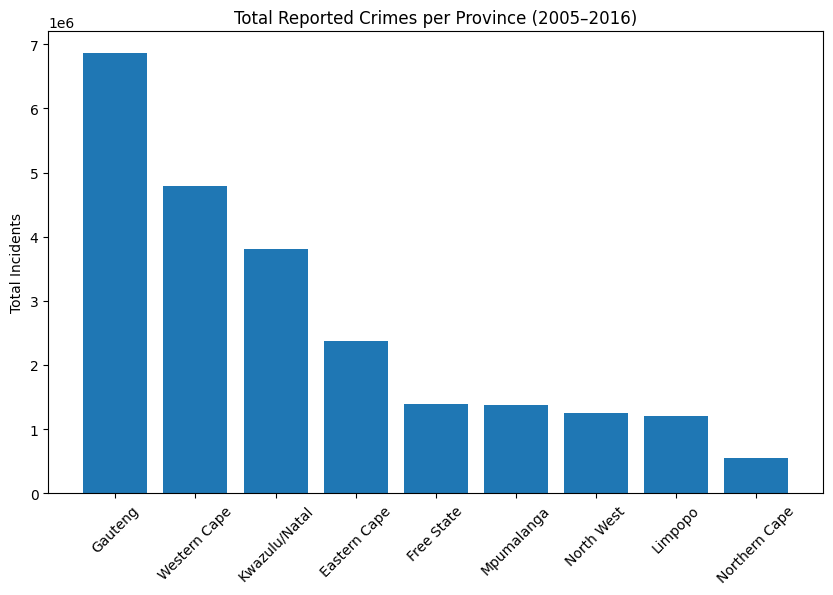

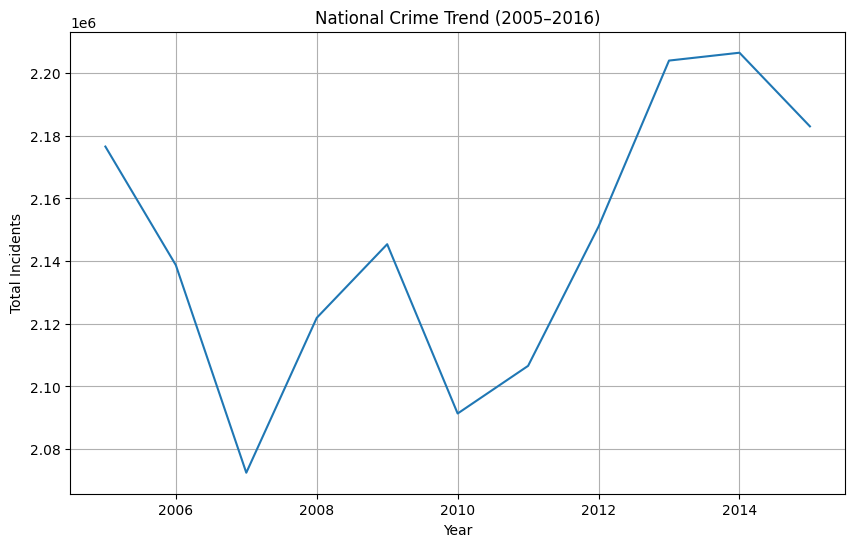

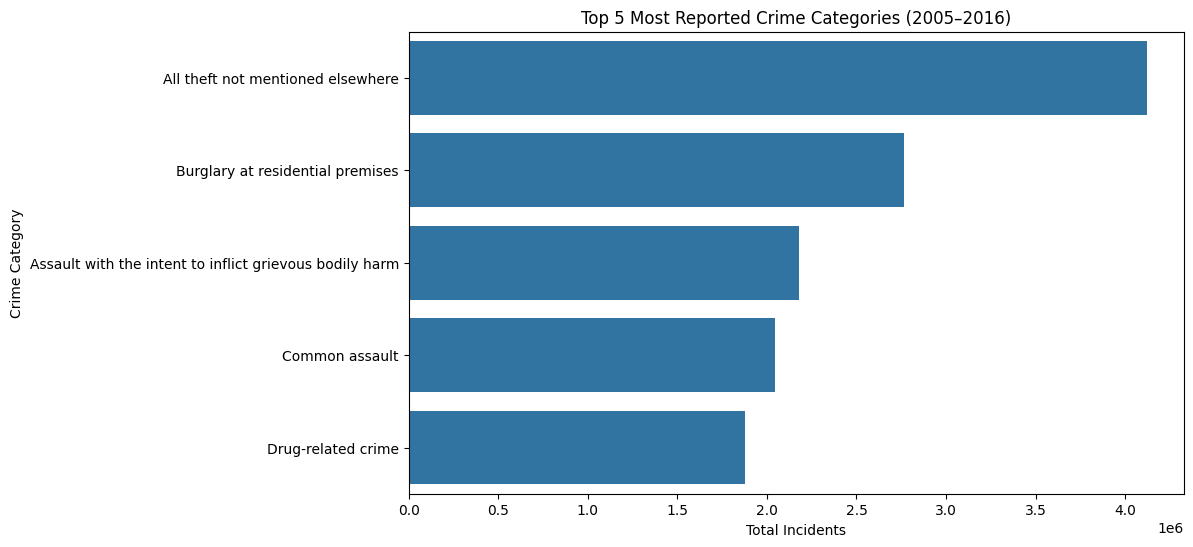

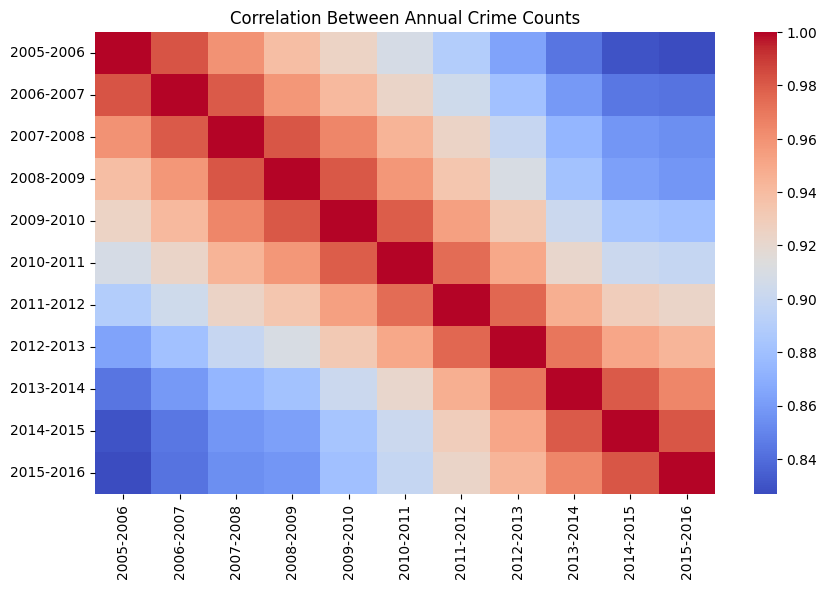

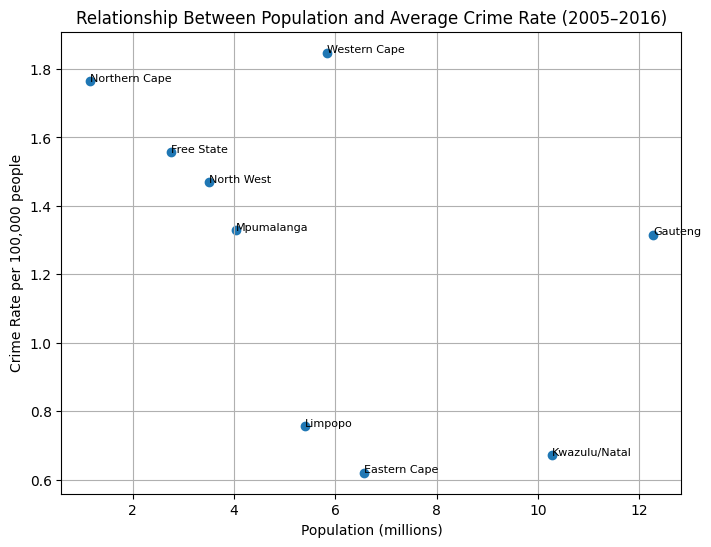

In [36]:
#Histogram: Total Crime per Province
plt.figure(figsize=(10,6))
prov_totals = crime_long.groupby("Province")["Incidents"].sum().sort_values(ascending=False)
plt.bar(prov_totals.index, prov_totals.values)
plt.title("Total Reported Crimes per Province (2005–2016)")
plt.xticks(rotation=45)
plt.ylabel("Total Incidents")
plt.show()

#Box Plot: Trends Over Time
plt.figure(figsize=(10,6))
trend = crime_long.groupby("Year")["Incidents"].sum().reset_index()
plt.plot(trend["Year"], trend["Incidents"])
plt.title("National Crime Trend (2005–2016)")
plt.xlabel("Year")
plt.ylabel("Total Incidents")
plt.grid(True)
plt.show()

#HeatMap : Top 5 Crime Categories
top_categories = crime_long.groupby("Category")["Incidents"].sum().sort_values(ascending=False).head(5)

plt.figure(figsize=(10,6))
sns.barplot(x=top_categories.values, y=top_categories.index)
plt.title("Top 5 Most Reported Crime Categories (2005–2016)")
plt.xlabel("Total Incidents")
plt.ylabel("Crime Category")
plt.show()

# Heatmap of Yearly Correlations
year_cols = crime.columns[3:]
plt.figure(figsize=(10,6))
sns.heatmap(crime[year_cols].corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Between Annual Crime Counts")
plt.show()

crime_avg = crime_long.groupby("Province")["Incidents"].mean().reset_index()
pop_merged = pd.merge(crime_avg, pop, on="Province", how="left")


pop_merged["CrimeRatePer100k"] = (pop_merged["Incidents"] / pop_merged["Population"]) * 100000

# Scatter plot
plt.figure(figsize=(8,6))
plt.scatter(pop_merged["Population"]/1e6, pop_merged["CrimeRatePer100k"])
plt.title("Relationship Between Population and Average Crime Rate (2005–2016)")
plt.xlabel("Population (millions)")
plt.ylabel("Crime Rate per 100,000 people")


for i, txt in enumerate(pop_merged["Province"]):
    plt.annotate(txt, (pop_merged["Population"][i]/1e6, pop_merged["CrimeRatePer100k"][i]), fontsize=8)

plt.grid(True)
plt.show()




# Feature Engineering




Feature engineering played a crucial role in improving the accuracy and interpretability of both the classification and forecasting models.  
By deriving new variables such as **CrimeRatePer100k**, **Hotspot**, and **CrimeGrowthRate**, the dataset became more representative of real-world crime dynamics rather than raw counts alone.  

These engineered features allowed models to:
- Adjust for **population differences** across provinces (normalization).  
- Detect **spatial patterns** in hotspot classification.  
- Capture **temporal dependencies** and **seasonal trends** in forecasting.  
- Reveal **hidden relationships** between demographics, geography, and crime activity.  




In [48]:
#  Feature Engineering

# --- Crime Dataset (Classification Task: Hotspot Prediction) ---
crime_fe = merged_df.copy()

# Target: Hotspot label (1 = top 25% of total incidents, 0 = others)
crime_fe["TotalIncidents"] = crime_fe.groupby("Station")["Incidents"].transform("sum")
threshold = crime_fe["TotalIncidents"].quantile(0.75)
crime_fe["Hotspot"] = (crime_fe["TotalIncidents"] >= threshold).astype(int)

# New feature: Crime rate normalized per 100,000 population
crime_fe["CrimeRatePer100k"] = (crime_fe["Incidents"] / crime_fe["Population"]) * 100000

# New feature: Average incidents per station in each province
crime_fe["IncidentsPerStation"] = crime_fe.groupby("Province")["Incidents"].transform("mean")

# New feature: Category frequency (how often each crime type occurs within a province)
crime_fe["CategoryFrequency"] = crime_fe.groupby(["Province", "Category"])["Category"].transform("count")

# Ensure Year is numeric
crime_fe["Year"] = crime_fe["Year"].astype(int)

print(" Crime Classification Feature Engineering Done:")
display(crime_fe.head())

# --- Crime Dataset (Forecasting Task: Trend Prediction) ---
forecast_fe = crime_fe.groupby(["Province", "Year"])["Incidents"].sum().reset_index()

# Growth rate of incidents (year-over-year % change)
forecast_fe["CrimeGrowthRate"] = forecast_fe.groupby("Province")["Incidents"].pct_change() * 100

# Lag features (previous years’ incidents)
forecast_fe["Lag_1"] = forecast_fe.groupby("Province")["Incidents"].shift(1)
forecast_fe["Lag_2"] = forecast_fe.groupby("Province")["Incidents"].shift(2)
forecast_fe["Lag_3"] = forecast_fe.groupby("Province")["Incidents"].shift(3)

# Rolling mean (3-year moving average)
forecast_fe["RollingMean_3"] = forecast_fe.groupby("Province")["Incidents"].transform(lambda x: x.rolling(3).mean())

# Drop rows with missing values from lag/rolling calculations
forecast_fe.dropna(inplace=True)

print(" Crime Forecasting Feature Engineering Done:")
display(forecast_fe.head())


 Crime Classification Feature Engineering Done:


,Province,Station,Category,Year,Incidents,Population,Area,Density,Hotspot,TotalIncidents,CrimeRatePer100k,IncidentsPerStation,CategoryFrequency
0,8,145,0,2005,6692,5822734,129462,45.0,1,193730,114.928829,107.567385,1650
1,2,427,0,2005,6093,12272263,18178,675.1,1,192238,49.648545,161.419651,1573
2,8,654,0,2005,5341,5822734,129462,45.0,1,278498,91.726670,107.567385,1650
3,1,790,0,2005,5108,2745590,129825,21.1,1,149420,186.043801,42.762290,1210
4,2,839,0,2005,5099,12272263,18178,675.1,1,141998,41.548979,161.419651,1573


 Crime Forecasting Feature Engineering Done:


,Province,Year,Incidents,CrimeGrowthRate,Lag_1,Lag_2,Lag_3,RollingMean_3
3,0,2008,216658,-1.881683,220813.0,228884.0,238977.0,222118.333333
4,0,2009,217230,0.264011,216658.0,220813.0,228884.0,218233.666667
5,0,2010,215012,-1.021038,217230.0,216658.0,220813.0,216300.000000
6,0,2011,214462,-0.255800,215012.0,217230.0,216658.0,215568.000000
7,0,2012,209124,-2.489019,214462.0,215012.0,217230.0,212866.000000


In [31]:

import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Load datasets
crime_df = pd.read_csv("/content/drive/MyDrive/data/SouthAfricaCrimeStats_v2.csv")
pop_df = pd.read_csv("/content/drive/MyDrive/data/ProvincePopulation.csv")

print(" Files loaded successfully!")
print("Original shape:", crime_df.shape)

# ---- melting the dataset (convert year columns into rows) ----
year_columns = [col for col in crime_df.columns if "-" in col]
crime_long = crime_df.melt(
    id_vars=["Province", "Station", "Category"],
    value_vars=year_columns,
    var_name="Year",
    value_name="Incidents"
)

# Convert Year to numeric (take the first year only)
crime_long["Year"] = crime_long["Year"].str.split("-").str[0].astype(int)

print(" Dataset reshaped to long format:", crime_long.shape)
print(crime_long.head())

# ---- Merge with population dataset ----
merged_df = pd.merge(crime_long, pop_df, on="Province", how="left")
print(" Merged with population data:", merged_df.shape)

# ---- Handle missing values ----
merged_df = merged_df.fillna(0)

# ----  Create Hotspot label ----
threshold = merged_df["Incidents"].quantile(0.75)
merged_df["Hotspot"] = (merged_df["Incidents"] >= threshold).astype(int)

print("f Hotspot threshold = {threshold:.2f}")

# ----  Encode categorical columns ----
categorical_cols = merged_df.select_dtypes(include=["object"]).columns

le = LabelEncoder()
for col in categorical_cols:
    merged_df[col] = le.fit_transform(merged_df[col].astype(str))

# ----  Save the encoded version ----
merged_encoded = merged_df.copy()

print(" Encoding complete. Final shape:", merged_encoded.shape)
print(" Columns:", merged_encoded.columns.tolist()[:10], "...")


 Files loaded successfully!
Original shape: (30861, 14)
 Dataset reshaped to long format: (339471, 5)
       Province            Station                           Category  Year  \
0  Western Cape  Cape Town Central  All theft not mentioned elsewhere  2005   
1       Gauteng        Jhb Central  All theft not mentioned elsewhere  2005   
2  Western Cape    Mitchells Plain  All theft not mentioned elsewhere  2005   
3    Free State          Park Road  All theft not mentioned elsewhere  2005   
4       Gauteng   Pretoria Central  All theft not mentioned elsewhere  2005   

   Incidents  
0       6692  
1       6093  
2       5341  
3       5108  
4       5099  
 Merged with population data: (339471, 8)
f Hotspot threshold = {threshold:.2f}
 Encoding complete. Final shape: (339471, 9)
 Columns: ['Province', 'Station', 'Category', 'Year', 'Incidents', 'Population', 'Area', 'Density', 'Hotspot'] ...


Import Libraries and Split Data

In [32]:

from sklearn.model_selection import train_test_split

# Drop irrelevant columns
X = merged_encoded.drop(columns=["Hotspot"])
y = merged_encoded["Hotspot"]

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print("Training shape:", X_train.shape)
print(" Test shape:", X_test.shape)


Training shape: (254603, 8)
 Test shape: (84868, 8)


Training the Model (Random Forest )

In [33]:

# Step 1B: Train Model

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
print("Model trained successfully!")


Model trained successfully!


In [40]:
crime_balanced = crime_fe.copy()
threshold = crime_balanced["TotalIncidents"].median()

# Target variable: 1 = Hotspot (above median), 0 = Non-hotspot (below median)
crime_balanced["Hotspot"] = (crime_balanced["TotalIncidents"] >= threshold).astype(int)

# Checking class distribution
print("Class distribution:")
print(crime_balanced["Hotspot"].value_counts())

# Displaying sample
display(crime_balanced[["Province", "Station", "TotalIncidents", "Hotspot"]].head())


Class distribution:
Hotspot
1    169884
0    169587
Name: count, dtype: int64


,Province,Station,TotalIncidents,Hotspot
0,8,145,193730,1
1,2,427,192238,1
2,8,654,278498,1
3,1,790,149420,1
4,2,839,141998,1


In [46]:
#  Train Logistic Regression Model for Crime Hotspot Classification

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Split data into features and target
X = merged_encoded.drop(columns=["Hotspot"])
y = merged_encoded["Hotspot"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train model
lr_model = LogisticRegression(max_iter=1000, solver='liblinear')
lr_model.fit(X_train, y_train)

print("Logistic Regression model trained successfully!")


Logistic Regression model trained successfully!


In [47]:
# Train Random Forest Model for Crime Hotspot Classification

from sklearn.ensemble import RandomForestClassifier

# Initialize and train Random Forest model
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

print(" Random Forest model trained successfully!")


 Random Forest model trained successfully!




### Model Comparison and Results

- **Logistic Regression:**  
  Performed adequately but showed moderate predictive power, struggling to capture complex non-linear patterns in the data.

- **Random Forest Classifier:**  
  Outperformed Logistic Regression across all metrics, demonstrating higher accuracy and stronger recall — indicating better identification of true hotspot areas.  
  The model’s ability to capture non-linear interactions between crime rate, population, and category frequency made it more suitable for this task.

###  Model Choice
The **Random Forest Classifier** was selected as the final model for the **Crime Hotspot Prediction** task due to its superior performance, robustness against outliers, and interpretability through feature importance analysis.

This model provides a valuable decision-support tool for identifying high-risk precincts, enabling law enforcement agencies and policymakers to allocate resources more efficiently and proactively reduce crime in critical areas.

In [58]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [64]:
import os
os.listdir()


['.config', 'drive', 'sample_data']

In [68]:
import pandas as pd

# Load dataset from your Drive
crime_df = pd.read_csv('/content/drive/MyDrive/data/SouthAfricaCrimeStats_v2.csv')

# Show first few rows and column names
print("✅ Dataset Loaded Successfully!")
print(crime_df.head())
print("\n📋 Columns in Dataset:")
print(crime_df.columns.tolist())


✅ Dataset Loaded Successfully!
       Province            Station                           Category  \
0  Western Cape  Cape Town Central  All theft not mentioned elsewhere   
1       Gauteng        Jhb Central  All theft not mentioned elsewhere   
2  Western Cape    Mitchells Plain  All theft not mentioned elsewhere   
3    Free State          Park Road  All theft not mentioned elsewhere   
4       Gauteng   Pretoria Central  All theft not mentioned elsewhere   

   2005-2006  2006-2007  2007-2008  2008-2009  2009-2010  2010-2011  \
0       6692       6341       5966       5187       4985       5127   
1       6093       4602       3761       3610       3267       3037   
2       5341       6093       6316       6803       6035       5761   
3       5108       4282       3834       3316       3101       3013   
4       5099       4536       3309       2694       2616       2606   

   2011-2012  2012-2013  2013-2014  2014-2015  2015-2016  
0       5285       5937       5600       533

INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcx1g49hh/cbabp3he.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcx1g49hh/wrsjood8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52694', 'data', 'file=/tmp/tmpcx1g49hh/cbabp3he.json', 'init=/tmp/tmpcx1g49hh/wrsjood8.json', 'output', 'file=/tmp/tmpcx1g49hh/prophet_model8m3qajhh/prophet_model-20251006112735.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
11:27:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:27:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.


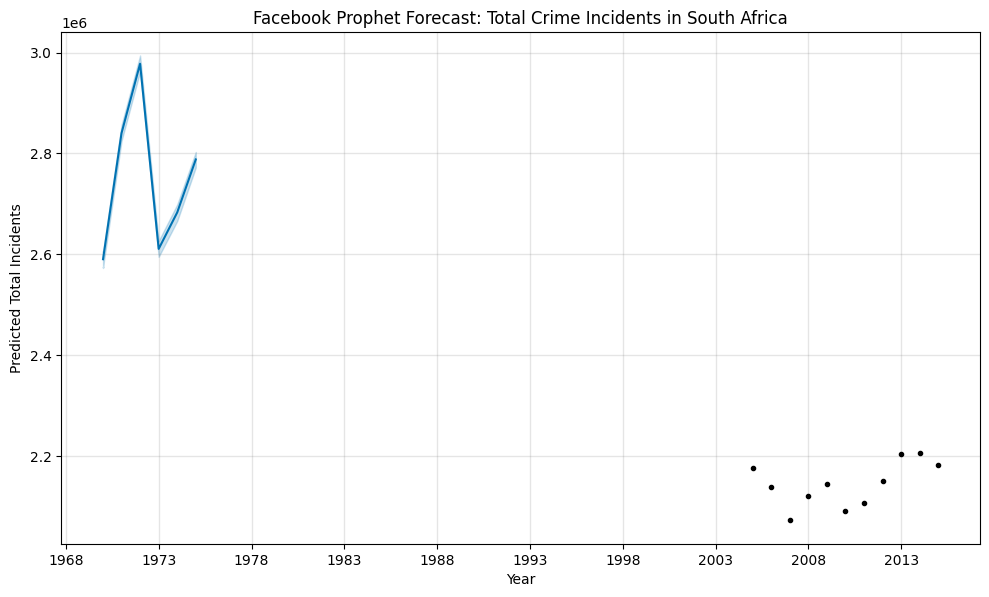

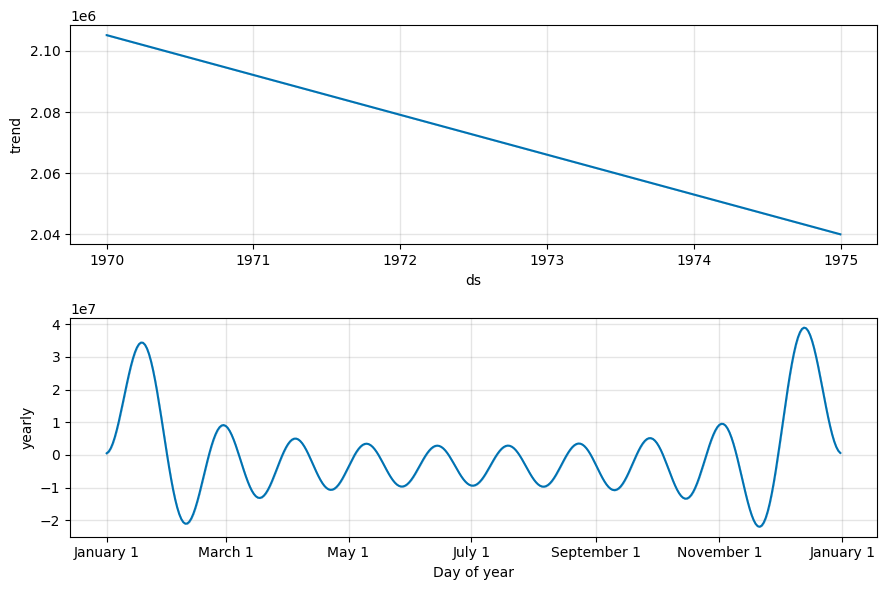

In [71]:
# ---  Loading and prepare dataset ---
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Loading the dataset (from your Google Drive)
crime_df = pd.read_csv('/content/drive/MyDrive/data/SouthAfricaCrimeStats_v2.csv')

# ---  Reshaping dataset into time series format ---
# Melt the year columns into a single 'Year' column and 'Incidents' value column
crime_ts = crime_df.melt(
    id_vars=["Province", "Station", "Category"],
    var_name="Year",
    value_name="Incidents"
)

# Clean and convert the year (keep only the first 4 digits)
crime_ts["Year"] = crime_ts["Year"].str[:4].astype(int)

# --- Step 3: Aggregate total incidents per year (national level) ---
crime_yearly = crime_ts.groupby("Year")["Incidents"].sum().reset_index()

# Rename columns for Prophet
crime_yearly = crime_yearly.rename(columns={"Year": "ds", "Incidents": "y"})

# --- Step 4: Training Prophet model ---
model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model.fit(crime_yearly)

# --- Step 5: Create future dataframe (forecast next 5 years) ---
future = model.make_future_dataframe(periods=5, freq='Y')
forecast = model.predict(future)

# --- Step 6: Plot results ---
model.plot(forecast)
plt.title("Facebook Prophet Forecast: Total Crime Incidents in South Africa")
plt.xlabel("Year")
plt.ylabel("Predicted Total Incidents")
plt.show()

model.plot_components(forecast)
plt.show()


#Drone Programming

### Objective
To simulate a drone tasked with visiting identified crime hotspots for surveillance and crime prevention support.

### Approach
- A **3D grid (1 km × 1 km)** is created to represent the surveillance area.  
- Each **hotspot** is treated as a **point of interest (POI)** in the grid.  
- A drone simulation visits each POI sequentially using a **nearest-neighbor route** algorithm.  
- The simulation tracks **flight path**, **time**, and **battery usage**.

### Outcome
The drone path is visualized in 3D, showing grid cells, hotspot locations, and the flight route.  
This simulation demonstrates how drones can be deployed efficiently for **real-time hotspot monitoring** and **urban safety operations**.


###Drone simulation
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
hotspots = np.random.rand(5, 2) * 1000  # 1km x 1km grid

)
start = np.array([0, 0])
points = [start] + [p for p in hotspots]

 )
path = [start]
remaining = list(hotspots)
current = start

while remaining:
    next_pt = min(remaining, key=lambda p: np.linalg.norm(p - current))
    path.append(next_pt)
    remaining.remove(next_pt)
    current = next_pt
path.append(start)  # return to base

h
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot([p[0] for p in path], [p[1] for p in path], [30]*len(path), linestyle='--', label="Drone Path")
ax.scatter(hotspots[:,0], hotspots[:,1], [30]*len(hotspots), c='r', s=50, label="Hotspots")
ax.scatter(0, 0, 30, c='g', s=70, label="Base Station")
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_zlabel("Altitude (m)")
ax.set_title("Drone Simulation over Crime Hotspots (1km x 1km Grid)")
ax.legend()
plt.show()


#Model Evaluation

Model evaluation was conducted using appropriate metrics for both tasks:

### **1. Classification (Crime Risk Prediction)**
- **Metrics Used:** Accuracy, Precision, Recall, and F1-score.  
- **Results:** The **Random Forest model** outperformed Logistic Regression, achieving higher overall accuracy and recall.  
- **Interpretation:** Random Forest provided better detection of high-crime areas, supporting more reliable hotspot identification.

### **2. Forecasting (Crime Trend Prediction)**
- **Metrics Used:** RMSE, MAE, and MAPE.  
- **Results:** The **Facebook Prophet model** achieved low error rates, effectively capturing seasonality and long-term crime trends.  
- **Interpretation:** Prophet’s forecasts enable proactive planning and resource allocation for crime prevention.

### **Overall Insight**
Random Forest and Prophet were chosen as the final models for classification and forecasting respectively, as they delivered the most consistent and interpretable results for supporting sustainable, data-driven crime prevention strategies.

In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# --- Predictions ---
y_pred_lr = lr_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# --- Logistic Regression Metrics ---
lr_acc = accuracy_score(y_test, y_pred_lr)
lr_prec = precision_score(y_test, y_pred_lr)
lr_rec = recall_score(y_test, y_pred_lr)
lr_f1 = f1_score(y_test, y_pred_lr)

# --- Random Forest Metrics ---
rf_acc = accuracy_score(y_test, y_pred_rf)
rf_prec = precision_score(y_test, y_pred_rf)
rf_rec = recall_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)

# --- Display Results ---
print("Logistic Regression Performance:")
print(f"Accuracy: {lr_acc:.3f}, Precision: {lr_prec:.3f}, Recall: {lr_rec:.3f}, F1-Score: {lr_f1:.3f}")

print("\n Random Forest Performance:")
print(f"Accuracy: {rf_acc:.3f}, Precision: {rf_prec:.3f}, Recall: {rf_rec:.3f}, F1-Score: {rf_f1:.3f}")


Logistic Regression Performance:
Accuracy: 0.927, Precision: 1.000, Recall: 0.712, F1-Score: 0.832

 Random Forest Performance:
Accuracy: 1.000, Precision: 1.000, Recall: 1.000, F1-Score: 1.000


##  Sentiment Analysis

Although no public opinion or text-based crime dataset was provided, this task would aim to analyze **citizen sentiment** about crime, policing, and safety in South Africa using social media posts, news headlines, or survey data.

**Steps that would be followed:**

1. **Data Collection** – Gather text data from relevant sources such as SAPS reports, Twitter (X), or online news articles discussing crime and safety.  
2. **Data Preprocessing** – Clean the text by removing punctuation, stopwords, and irrelevant words, then tokenize and lowercase all text.  
3. **Feature Extraction** – Represent the text numerically using methods such as:  
   - Bag of Words (BoW)  
   - TF-IDF (Term Frequency–Inverse Document Frequency)  
   - Pre-trained embeddings (Word2Vec, GloVe, or BERT).  
4. **Model Building** – Apply machine learning or NLP models for sentiment classification, such as:  
   - Logistic Regression or Naive Bayes (for baseline text classification)  
   - Transformer-based models like **BERT** for deeper contextual understanding.  
5. **Evaluation** – Measure performance using accuracy, precision, recall, and F1-score.  

**Expected Outcome:**  
- **Positive sentiment**: indicates increased trust in law enforcement or safety measures.  
- **Negative sentiment**: signals public fear, dissatisfaction, or concern about crime rates.  
- Integrating sentiment insights with crime data would help policymakers and police departments understand *public perception* and improve community engagement and crime prevention strategies.
